# Análisis hardware de cada prompt (Versión en Python de MonitorSystem con multihilos) V1
## Metodología
La estructura de la obtención de datos ees la siguiente: 

0. Durante los 5 segundos previos obtenemos métricas hardware cada medio segundo.
1. En 2 hilos paralelos alimentar el prompt por un lado.
2. Tras finalizar la ejecución de los 2 hilos, seguir tomando medidas durante 5 segundos(misma forma que el punto 0).
3. Descargar/cerrar clientes/modelos.
4. Tomar durante otros 5 segundos medidas hardware(punto 0).
Temperatura(generativa)  no se ha tocado
Nótese que deepseek ignora l parametro de no thinking

In [1]:
# Codigo para la adición de librerias externas en Python
import sys
from pathlib import Path

# Añadimos la librerias comunes 
project_root = Path().absolute().parent.parent
sys.path.insert(0, str(project_root))
from common.lib.clase_mejorada import metricas


In [2]:
#importación de librerias estandar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json


## Sobre los modelos utilizados
La mayoría son procedentes de ollama cloud con los siguientes paraḿetros: 

    - Mistral :     parameters          7.2B , context length      32768 , embedding length    4096 , quantization ,   Q4_K_M  
    - Salamandra:  parameters      7.8B  , context length      8192  , embedding length    4096  ,quantization  Q4_K_M    
    - deepseek:      parameters          1.8B   ,context length      131072 , embedding length    1536 ,quantization        Q4_K_M  
    - qwen:      parameters          494.03M  ,context length      32768 ,  embedding length    896 ,quantization        Q4_K_M     
Sin embargo, Ollama ignora el valor que aparece en los modelfiles sustituyendolo por un valor de 4096 por defecto.(comprobado haciendo ollama ps mientras se ejecutaba) idem, con el batch size(que según la documentación que pulula por internet es 512 por defecto, cosa que me parece extraña).

## Con ventilador


In [3]:
#Adicion de los archivos de datos
qwen_metrics = metricas.parser(
    'dataset/Vent/ollama/OLLAMA_hardwaremetrics_2025-10-20-17-02_qwen2.5:0.5b.jsonl',
    'dataset/Vent/ollama/OLLAMA_promptmetrics_2025-10-20-17-02_qwen2.5:0.5b.jsonl'
)

mistral_metrics = metricas.parser(
    'dataset/Vent/ollama/OLLAMA_hardwaremetrics_2025-10-20-16-40_mistral:7b.jsonl',
    'dataset/Vent/ollama/OLLAMA_promptmetrics_2025-10-20-16-40_mistral:7b.jsonl'
)

deepseek_metrics = metricas.parser(
    'dataset/Vent/ollama/OLLAMA_hardwaremetrics_2025-10-20-16-49_deepseek-r1:1.5b.jsonl',
    'dataset/Vent/ollama/OLLAMA_promptmetrics_2025-10-20-16-49_deepseek-r1:1.5b.jsonl'
)

salamandra_metrics = metricas.parser(
    'dataset/Vent/ollama/OLLAMA_hardwaremetrics_2025-10-20-16-55_cas-salamandra-7b-instruct:latest.jsonl',
    'dataset/Vent/ollama/OLLAMA_promptmetrics_2025-10-20-16-55_cas-salamandra-7b-instruct:latest.jsonl'
)
ollama_metricas = [qwen_metrics, mistral_metrics, deepseek_metrics, salamandra_metrics]

## CPU 

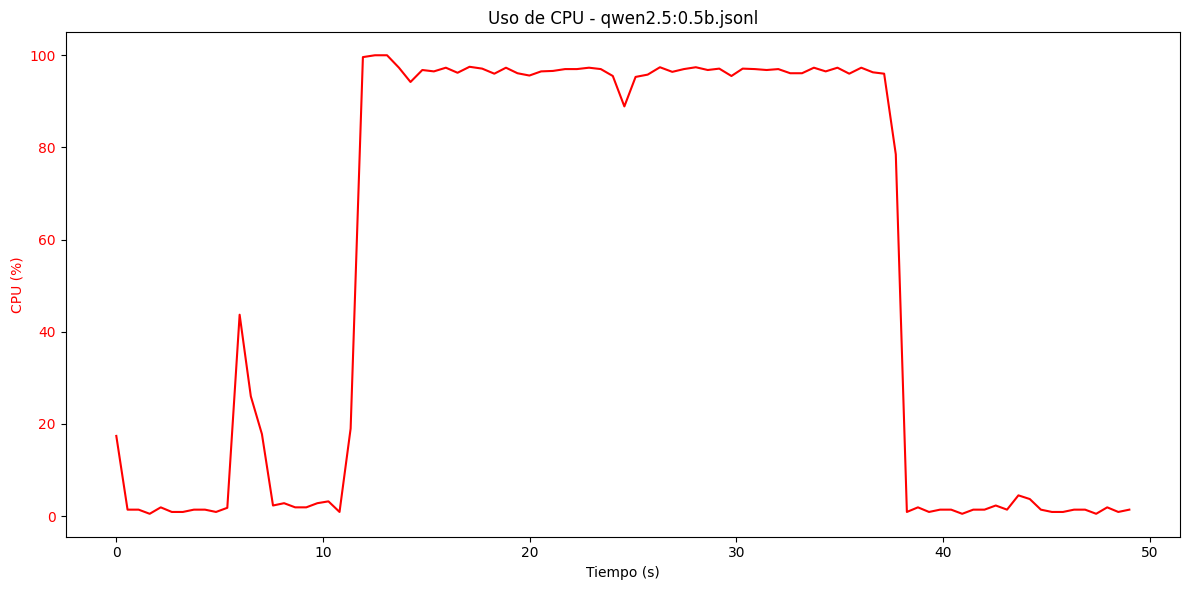

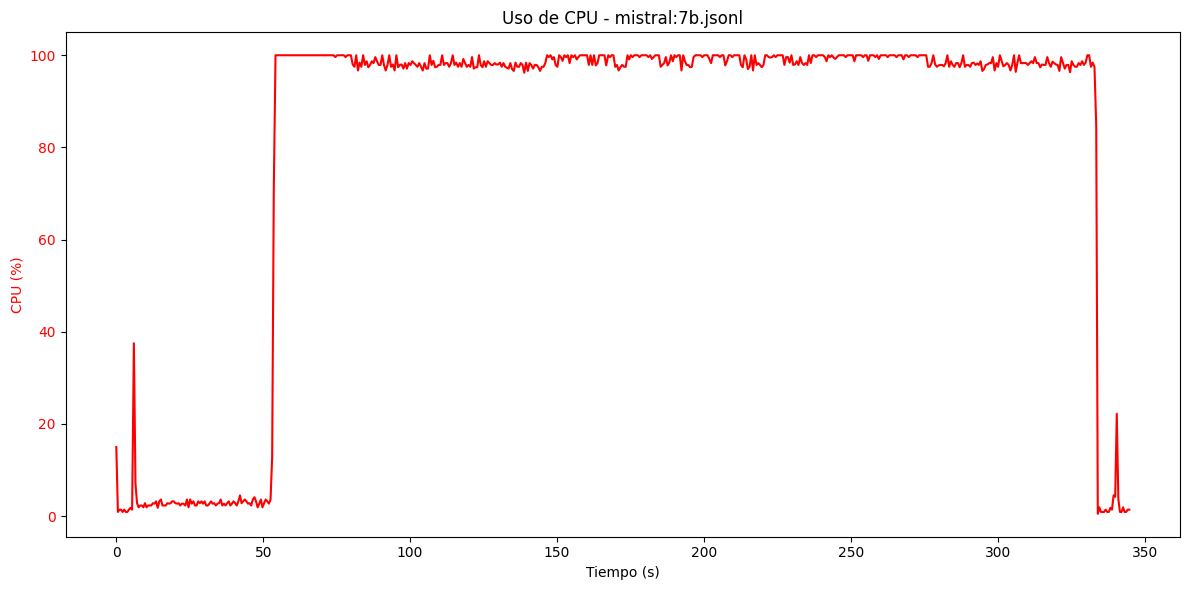

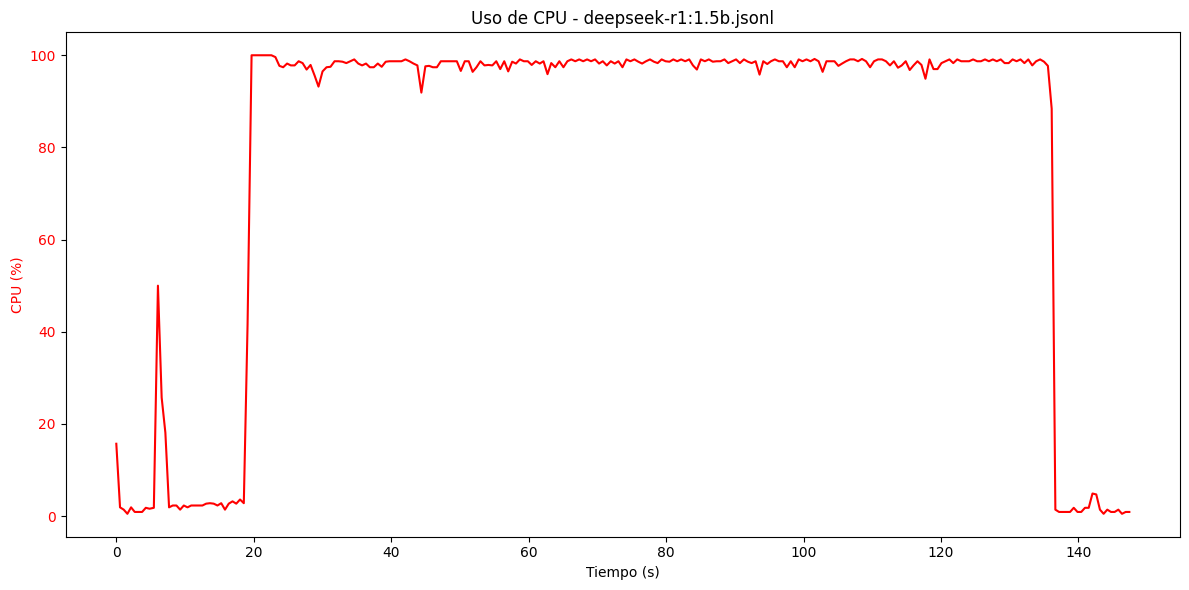

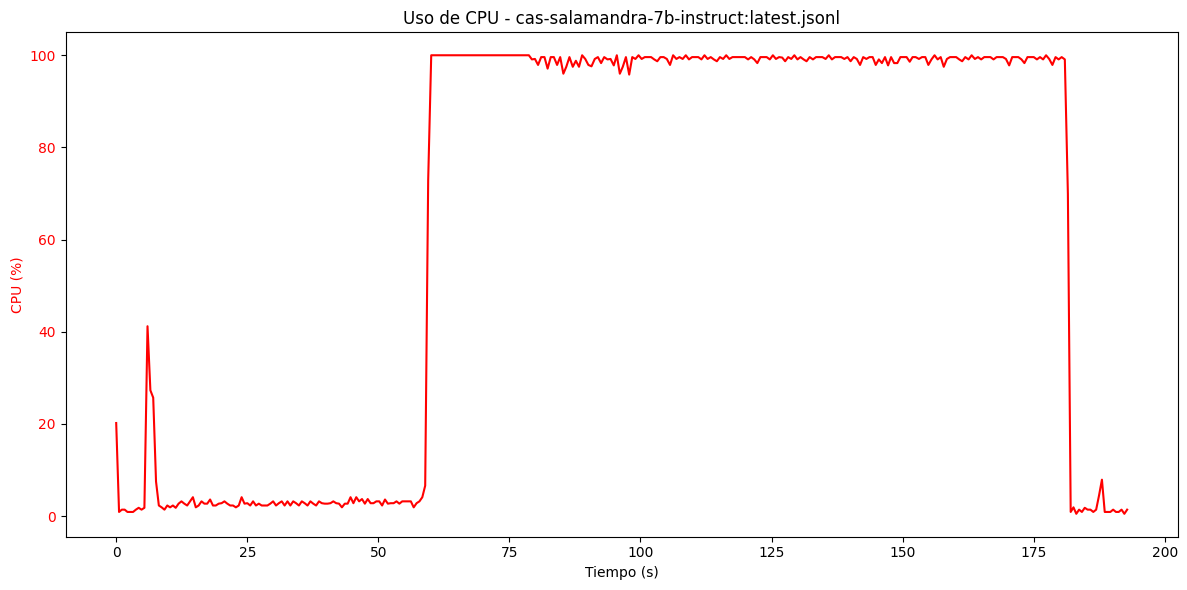

In [4]:


def plot_cpu(metrics):
    """Generar gráficos de uso de CPU y frecuencia para cada modelo y prompt"""
    model_name = metrics.get_model()
    hw_data = metrics.get_hardware_pd()

    if hw_data.empty:
        print(f"No hay datos de hardware para el modelo {model_name}")
        return

    # Filtrar datos inválidos
    hw_data = hw_data[hw_data['cpu_usage'] != -1]
    

    if hw_data.empty:
        print(f"No hay datos válidos para el modelo {model_name}")
        return

    # Convertir timestamps a segundos relativos
    hw_data['time_dt'] = pd.to_datetime(hw_data['timestamp'], unit='ns')
    start_time = hw_data['time_dt'].min()
    hw_data['t_s'] = (hw_data['time_dt'] - start_time).dt.total_seconds()

    # Crear gráfico
    fig, ax1 = plt.subplots(figsize=(12, 6))

    ax1.set_title(f"Uso de CPU - {model_name}")
    ax1.set_xlabel("Tiempo (s)")
    ax1.set_ylabel("CPU (%)", color="red")
    ax1.plot(hw_data['t_s'], hw_data['cpu_usage'], color="red", label="CPU (%)")
    ax1.tick_params(axis="y", labelcolor="red")


    fig.tight_layout()
    plt.show()

# Generar gráficos para cada modelo
for metrics in ollama_metricas:
    plot_cpu(metrics)


### Temperatura

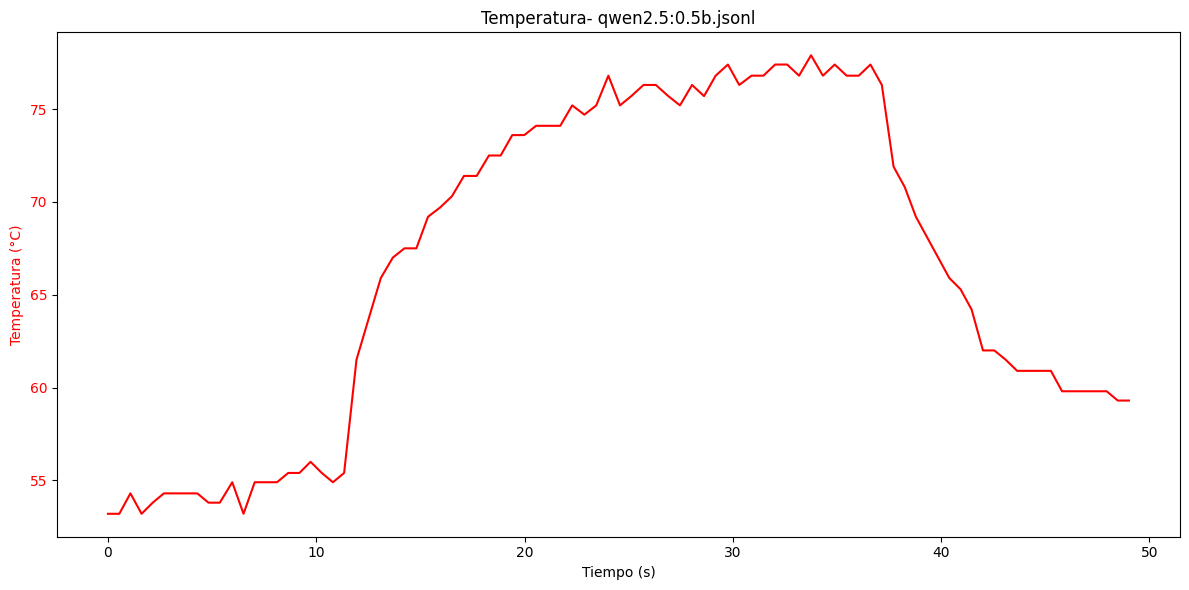

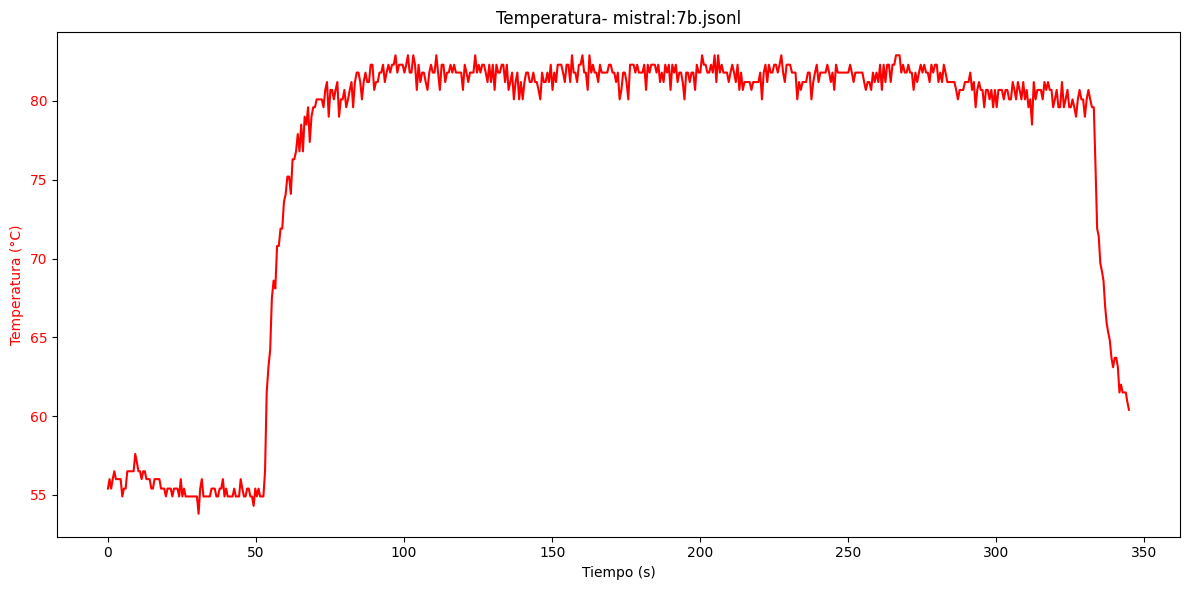

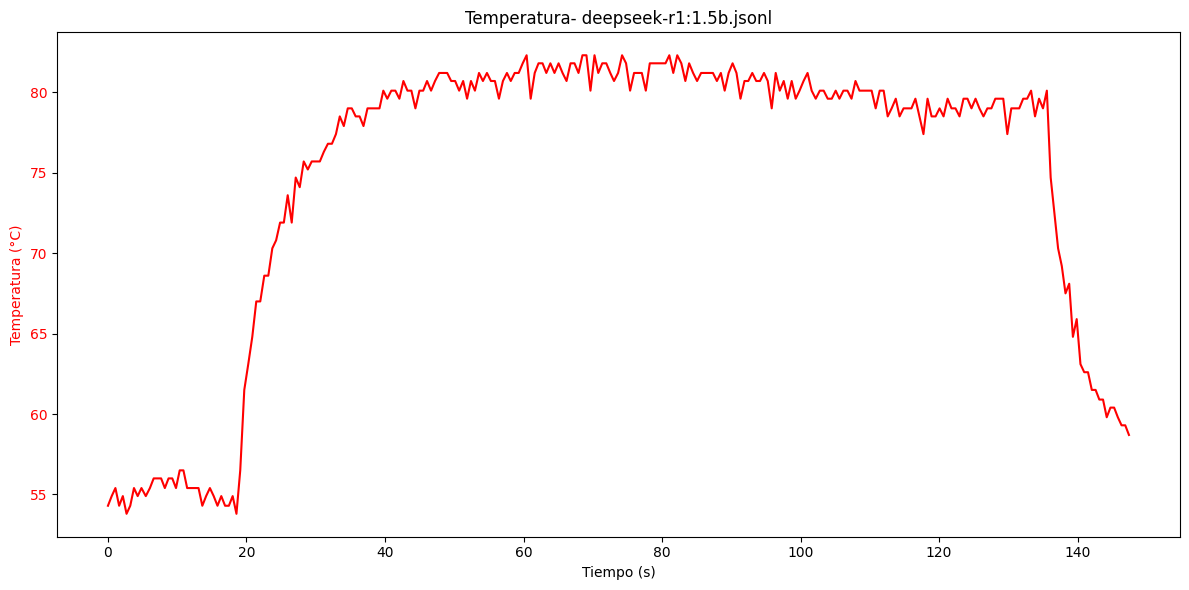

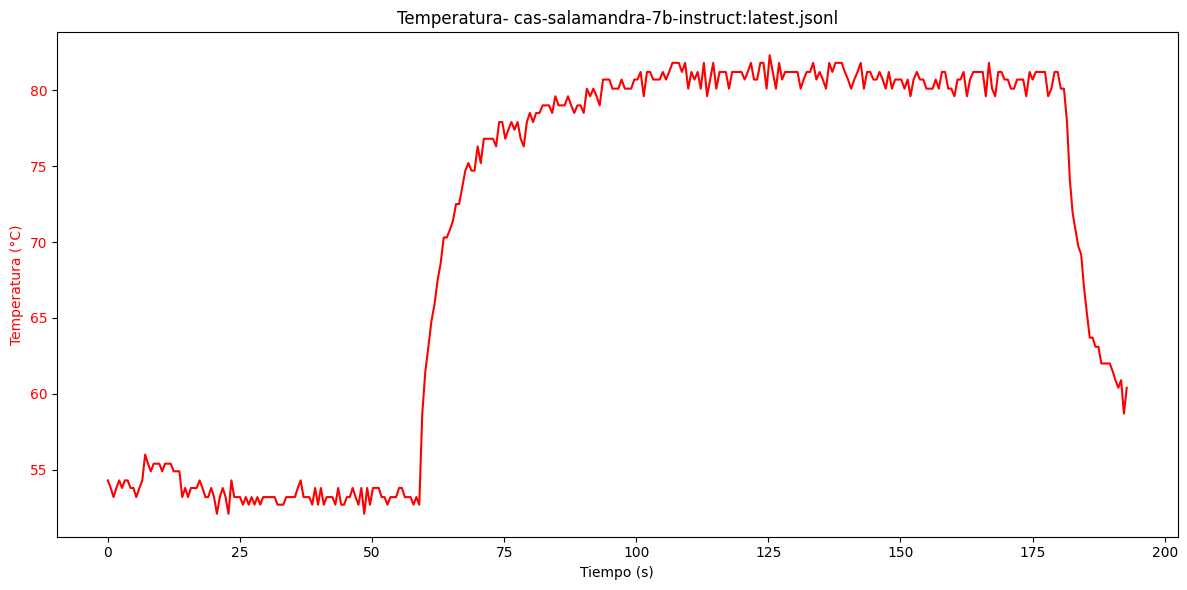

In [5]:
def plot_temp(metrics):
    """Generar gráficos de uso de CPU y frecuencia para cada modelo y prompt"""
    model_name = metrics.get_model()
    hw_data = metrics.get_hardware_pd()

    if hw_data.empty:
        print(f"No hay datos de hardware para el modelo {model_name}")
        return

    # Filtrar datos inválidos
    hw_data = hw_data[hw_data['cpu_usage'] != -1]
    

    if hw_data.empty:
        print(f"No hay datos válidos para el modelo {model_name}")
        return

    # Convertir timestamps a segundos relativos
    hw_data['time_dt'] = pd.to_datetime(hw_data['timestamp'], unit='ns')
    start_time = hw_data['time_dt'].min()
    hw_data['t_s'] = (hw_data['time_dt'] - start_time).dt.total_seconds()

    # Crear gráfico
    fig, ax1 = plt.subplots(figsize=(12, 6))

    ax1.set_title(f"Temperatura- {model_name}")
    ax1.set_xlabel("Tiempo (s)")
    ax1.set_ylabel("Temperatura (°C)", color="red")
    ax1.plot(hw_data['t_s'], hw_data['temperature'], color="red", label="Temperatura (°C)")
    ax1.tick_params(axis="y", labelcolor="red")


    fig.tight_layout()
    plt.show()

# Generar gráficos para cada modelo
for metrics in ollama_metricas:
    plot_temp(metrics)


### Analisis CPU y Frecuencia

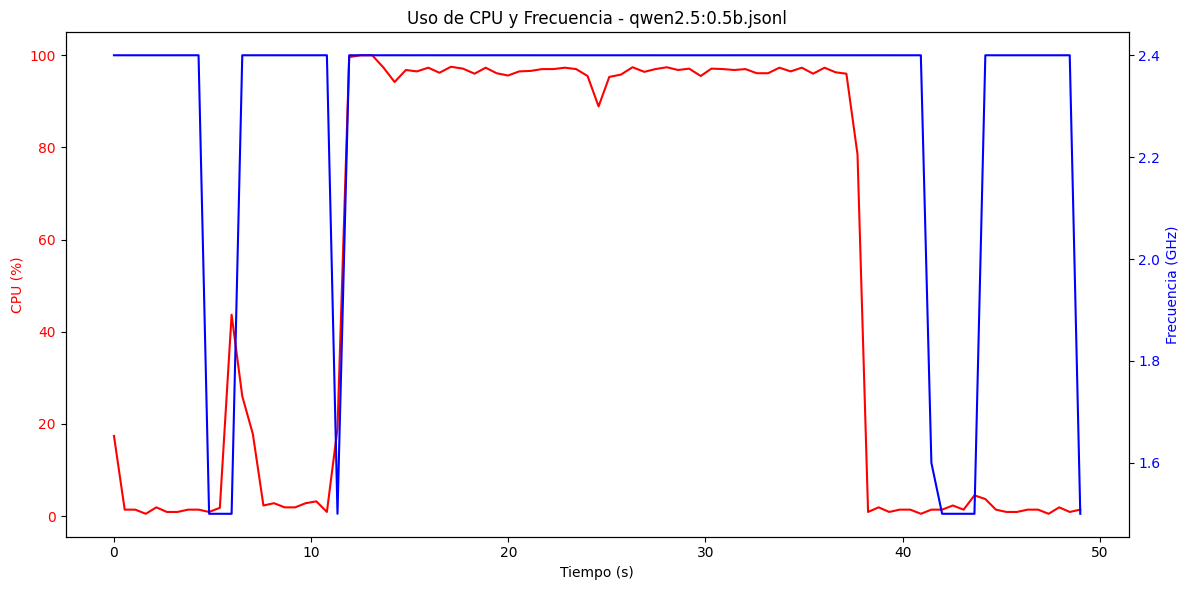

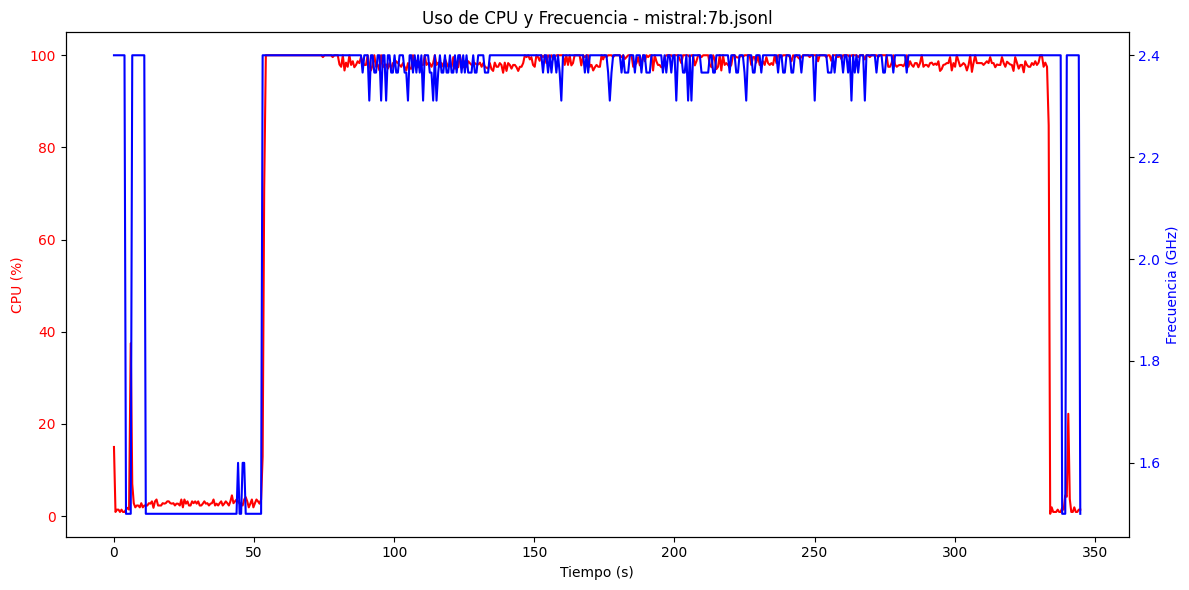

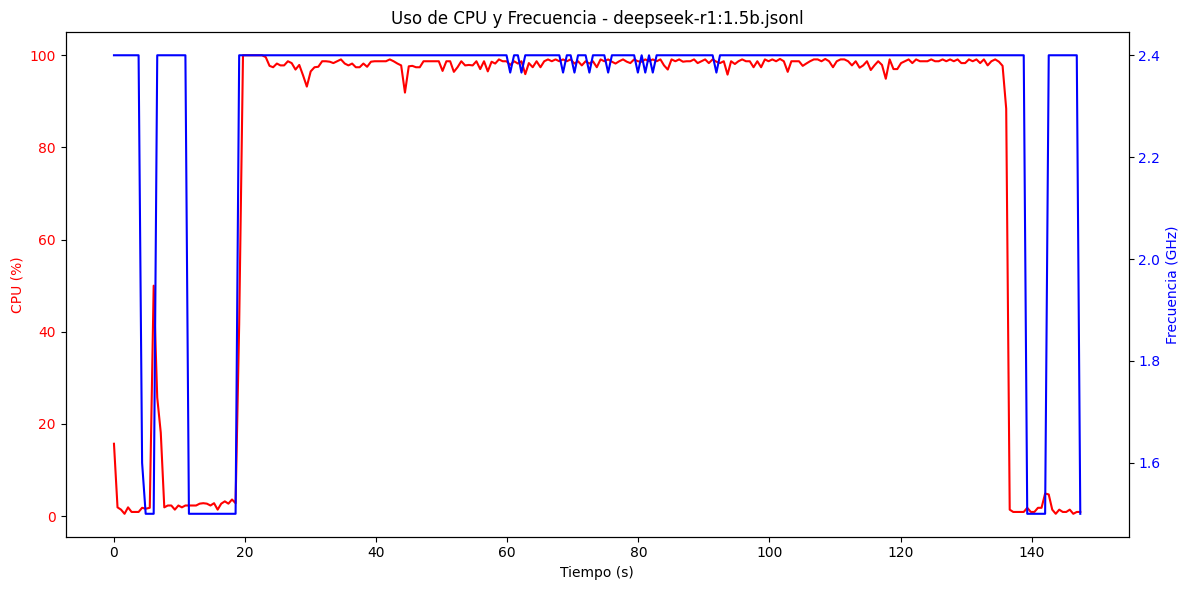

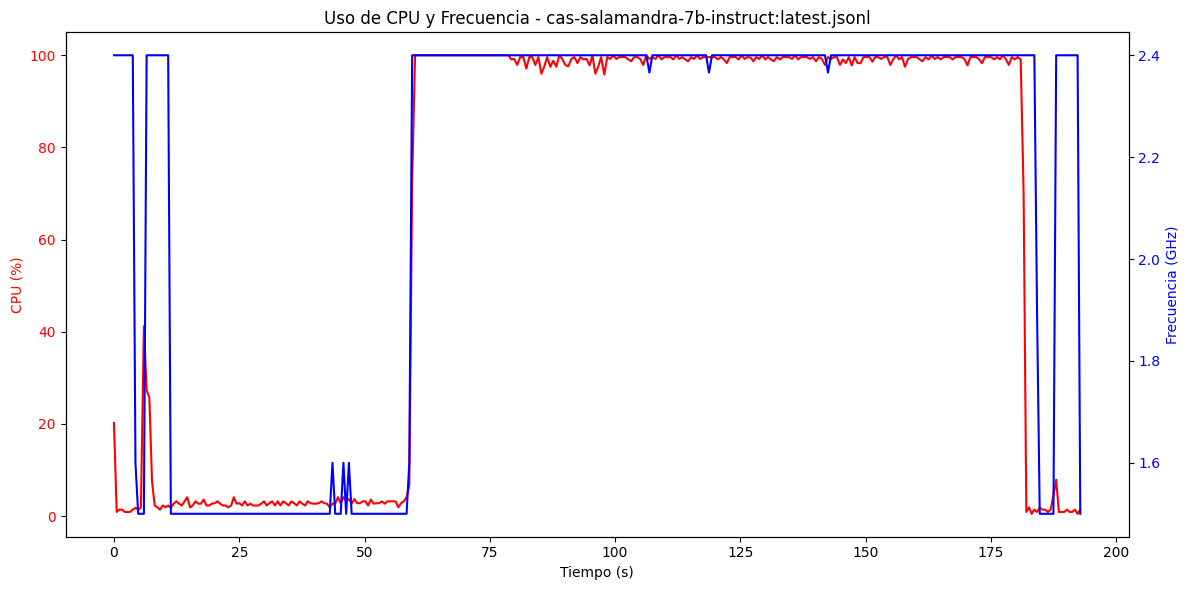

In [6]:
import matplotlib.pyplot as plt

def plot_cpu_frequency(metrics):
    """Generar gráficos de uso de CPU y frecuencia para cada modelo y prompt"""
    model_name = metrics.get_model()
    hw_data = metrics.get_hardware_pd()

    if hw_data.empty:
        print(f"No hay datos de hardware para el modelo {model_name}")
        return

    # Filtrar datos inválidos
    hw_data = hw_data[hw_data['cpu_usage'] != -1]
    hw_data = hw_data[hw_data['frequency'] != -1]

    if hw_data.empty:
        print(f"No hay datos válidos para el modelo {model_name}")
        return

    # Convertir timestamps a segundos relativos
    hw_data['time_dt'] = pd.to_datetime(hw_data['timestamp'], unit='ns')
    start_time = hw_data['time_dt'].min()
    hw_data['t_s'] = (hw_data['time_dt'] - start_time).dt.total_seconds()

    # Crear gráfico
    fig, ax1 = plt.subplots(figsize=(12, 6))

    ax1.set_title(f"Uso de CPU y Frecuencia - {model_name}")
    ax1.set_xlabel("Tiempo (s)")
    ax1.set_ylabel("CPU (%)", color="red")
    ax1.plot(hw_data['t_s'], hw_data['cpu_usage'], color="red", label="CPU (%)")
    ax1.tick_params(axis="y", labelcolor="red")

    ax2 = ax1.twinx()
    ax2.set_ylabel("Frecuencia (GHz)", color="blue") 
    ax2.plot(hw_data['t_s'], hw_data['frequency'] / 1_000_000_000, color="blue", label="Frecuencia (GHz)")
    ax2.tick_params(axis="y", labelcolor="blue")

    fig.tight_layout()
    plt.show()

# Generar gráficos para cada modelo
for metrics in ollama_metricas:
    plot_cpu_frequency(metrics)


#### CPU y Temperatura 


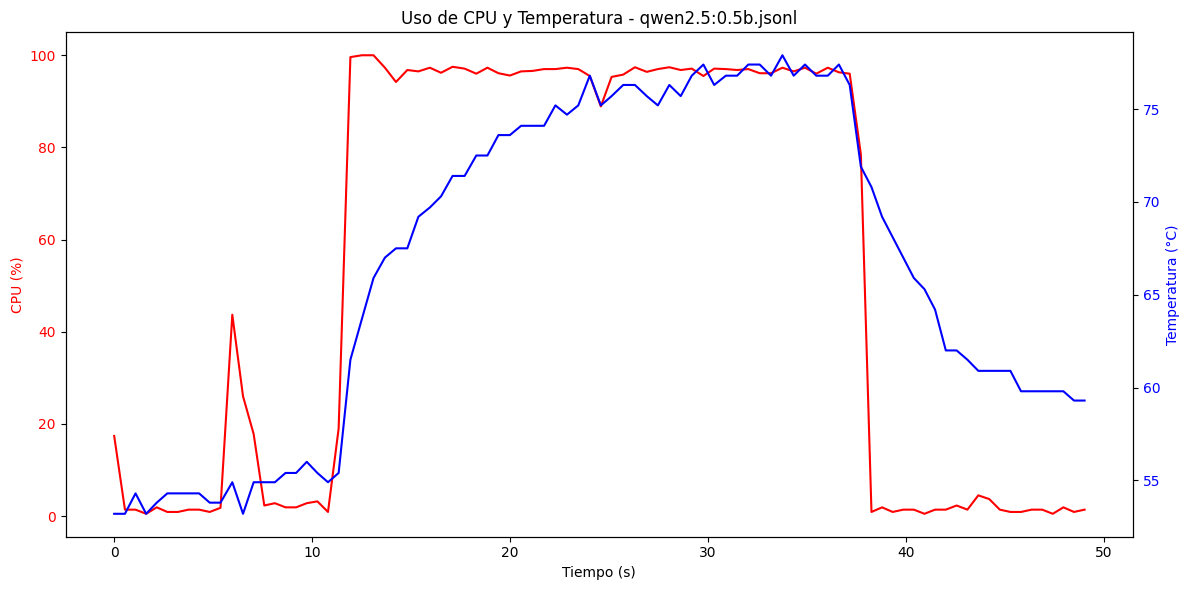

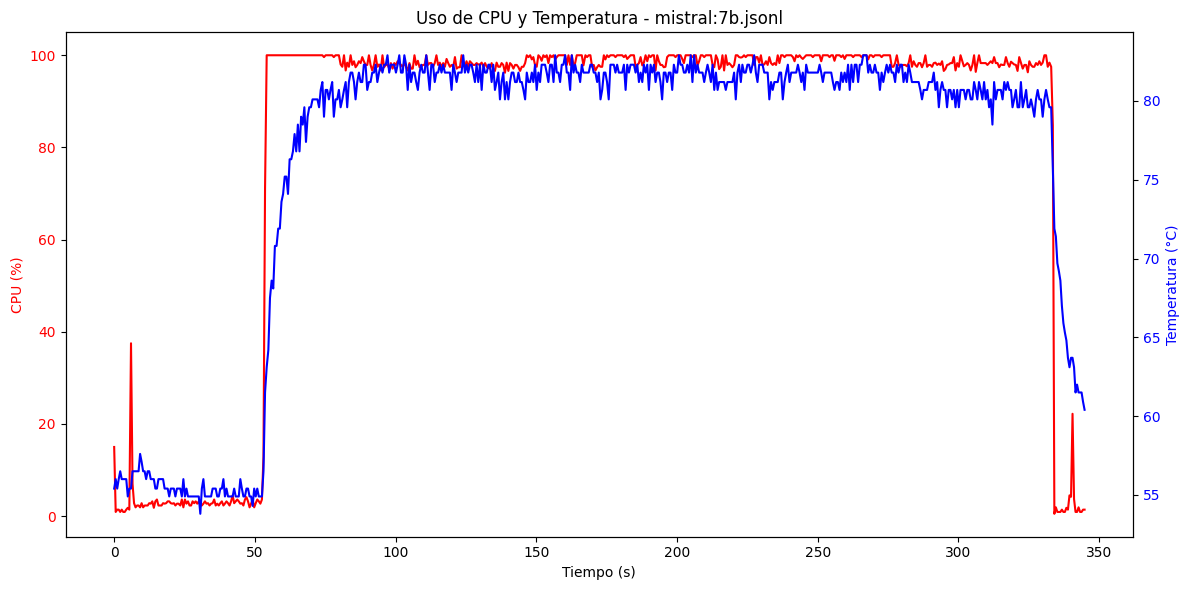

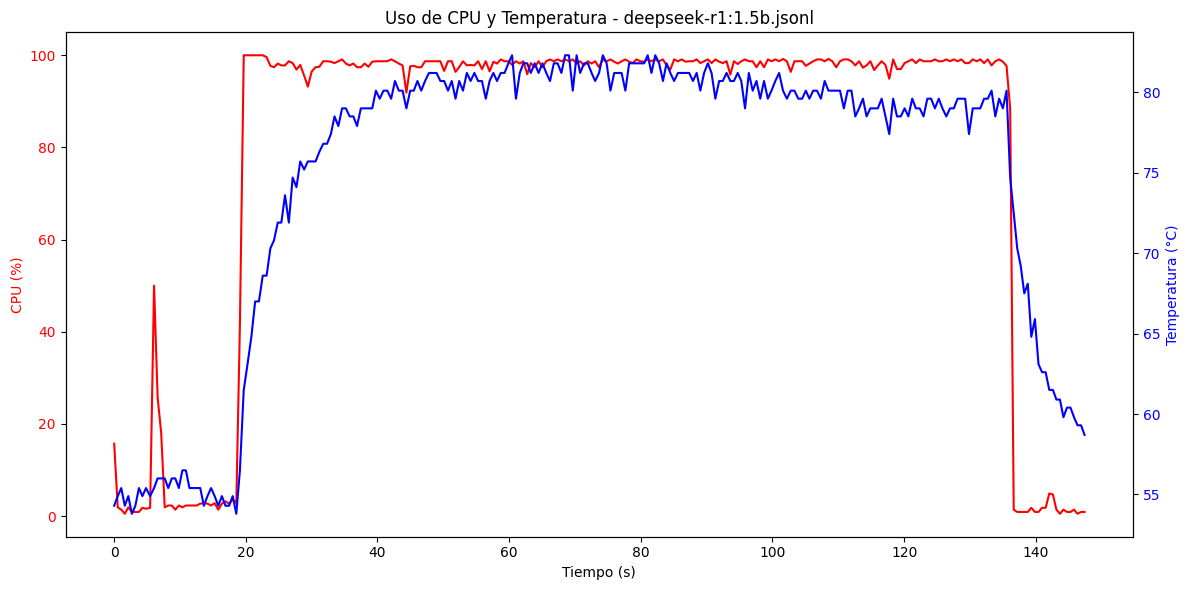

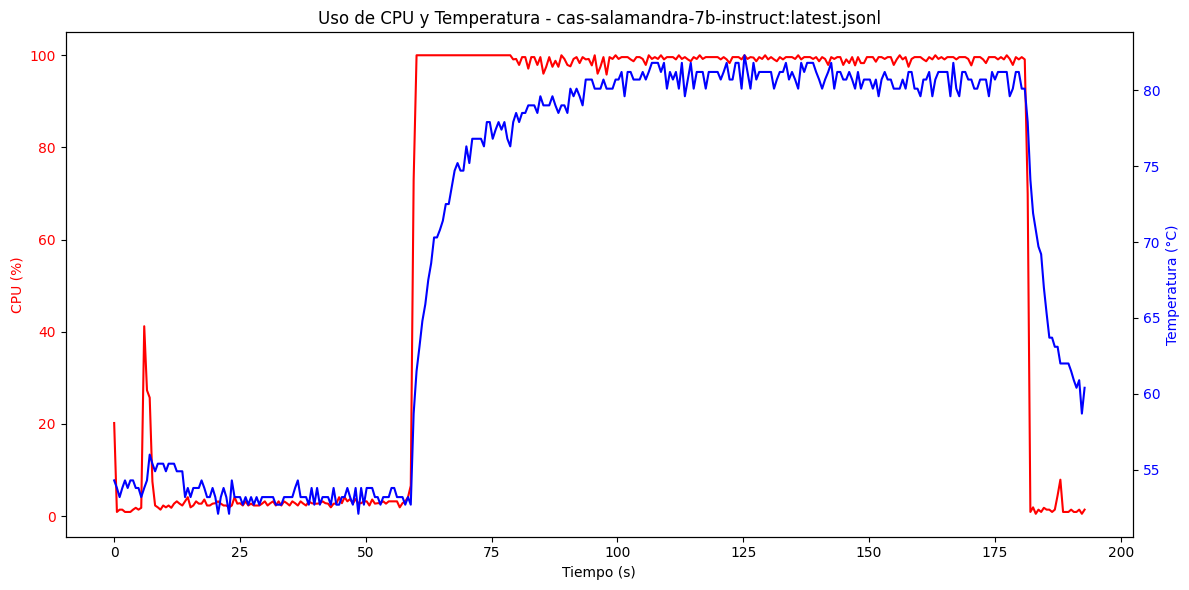

In [7]:
import matplotlib.pyplot as plt

def plot_temp_frequency(metrics):
    """Generar gráficos de uso de CPU y frecuencia para cada modelo y prompt"""
    model_name = metrics.get_model()
    hw_data = metrics.get_hardware_pd()

    if hw_data.empty:
        print(f"No hay datos de hardware para el modelo {model_name}")
        return

    # Filtrar datos inválidos
    hw_data = hw_data[hw_data['cpu_usage'] != -1]
    hw_data = hw_data[hw_data['frequency'] != -1]

    if hw_data.empty:
        print(f"No hay datos válidos para el modelo {model_name}")
        return

    # Convertir timestamps a segundos relativos
    hw_data['time_dt'] = pd.to_datetime(hw_data['timestamp'], unit='ns')
    start_time = hw_data['time_dt'].min()
    hw_data['t_s'] = (hw_data['time_dt'] - start_time).dt.total_seconds()

    # Crear gráfico
    fig, ax1 = plt.subplots(figsize=(12, 6))

    ax1.set_title(f"Uso de CPU y Temperatura - {model_name}")
    ax1.set_xlabel("Tiempo (s)")
    ax1.set_ylabel("CPU (%)", color="red")
    ax1.plot(hw_data['t_s'], hw_data['cpu_usage'], color="red", label="CPU (%)")
    ax1.tick_params(axis="y", labelcolor="red")

    ax2 = ax1.twinx()
    ax2.set_ylabel("Temperatura (°C)", color="blue") 
    ax2.plot(hw_data['t_s'], hw_data['temperature'], color="blue", label="Temperatura (°C)")
    ax2.tick_params(axis="y", labelcolor="blue")

    fig.tight_layout()
    plt.show()

# Generar gráficos para cada modelo
for metrics in ollama_metricas:
    plot_temp_frequency(metrics)

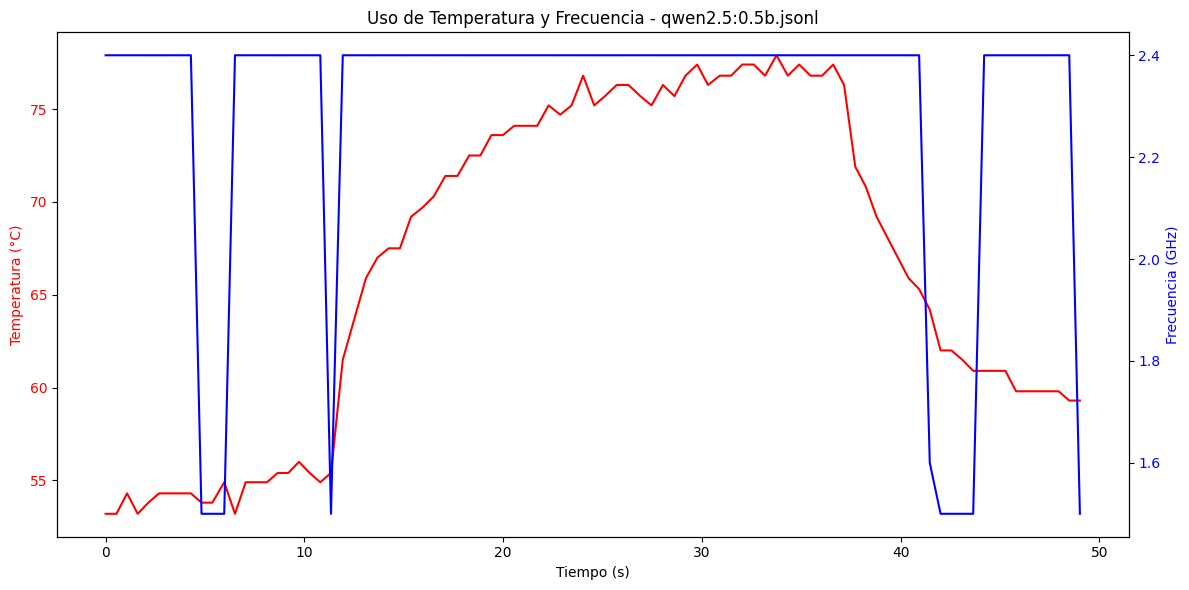

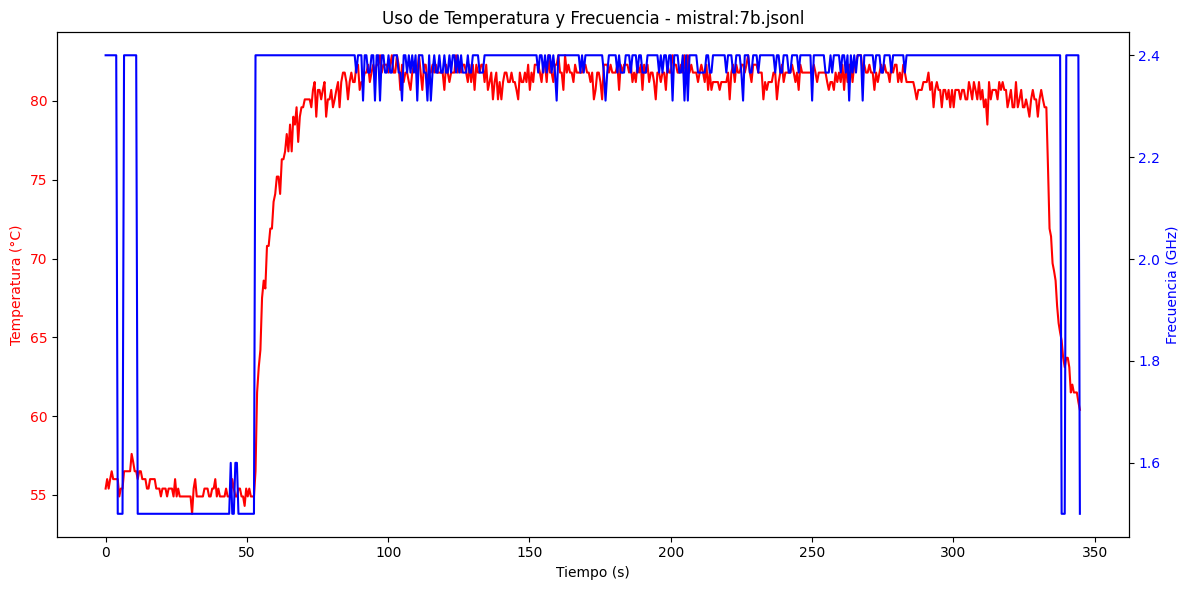

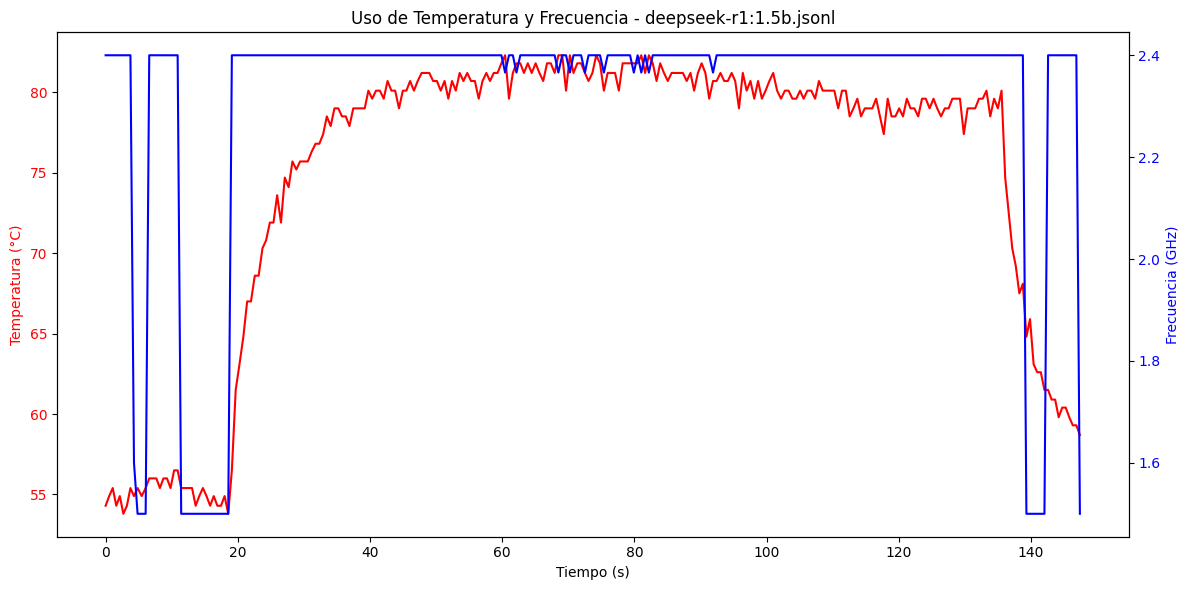

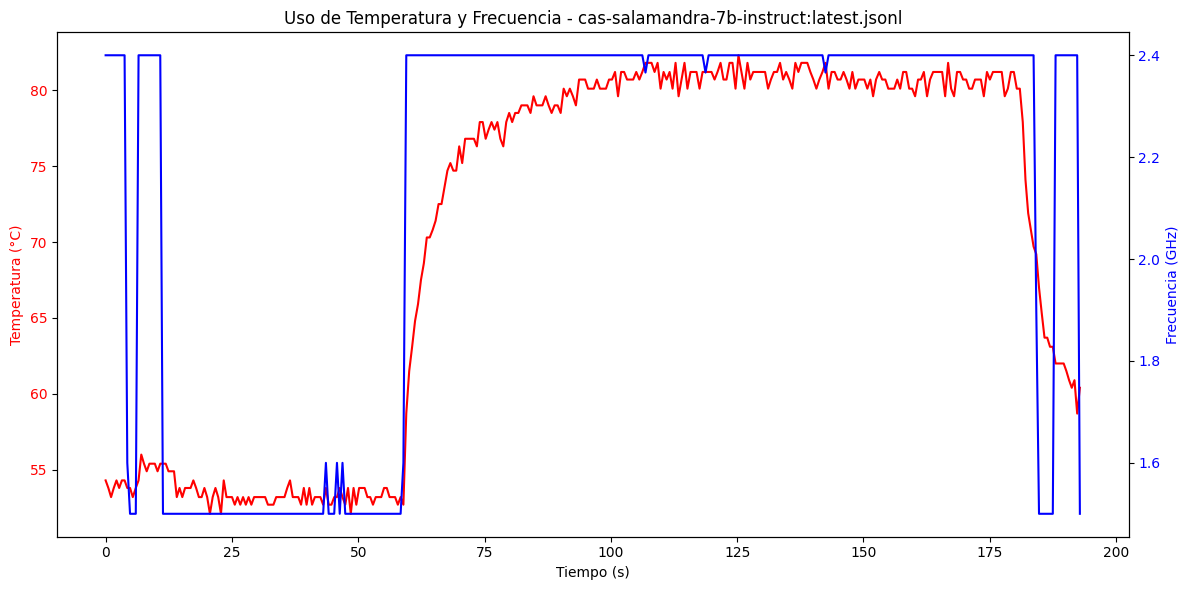

In [8]:
### Temperatura y Frecuencia
import matplotlib.pyplot as plt

def plot_temp_frequency(metrics):
    """Generar gráficos de uso de temperatura y frecuencia para cada modelo y prompt"""
    model_name = metrics.get_model()
    hw_data = metrics.get_hardware_pd()

    if hw_data.empty:
        print(f"No hay datos de hardware para el modelo {model_name}")
        return

    # Filtrar datos inválidos
    hw_data = hw_data[hw_data['temperature'] != -1]
    hw_data = hw_data[hw_data['frequency'] != -1]

    if hw_data.empty:
        print(f"No hay datos válidos para el modelo {model_name}")
        return

    # Convertir timestamps a segundos relativos
    hw_data['time_dt'] = pd.to_datetime(hw_data['timestamp'], unit='ns')
    start_time = hw_data['time_dt'].min()
    hw_data['t_s'] = (hw_data['time_dt'] - start_time).dt.total_seconds()

    # Crear gráfico
    fig, ax1 = plt.subplots(figsize=(12, 6))

    ax1.set_title(f"Uso de Temperatura y Frecuencia - {model_name}")
    ax1.set_xlabel("Tiempo (s)")
    ax1.set_ylabel("Temperatura (°C)", color="red")
    ax1.plot(hw_data['t_s'], hw_data['temperature'], color="red", label="Temperatura (°C)")
    ax1.tick_params(axis="y", labelcolor="red")

    ax2 = ax1.twinx()
    ax2.set_ylabel("Frecuencia (GHz)", color="blue") 
    ax2.plot(hw_data['t_s'], hw_data['frequency'] / 1_000_000_000, color="blue", label="Frecuencia (GHz)")
    ax2.tick_params(axis="y", labelcolor="blue")

    fig.tight_layout()
    plt.show()

# Generar gráficos para cada modelo
for metrics in ollama_metricas:
    plot_temp_frequency(metrics)

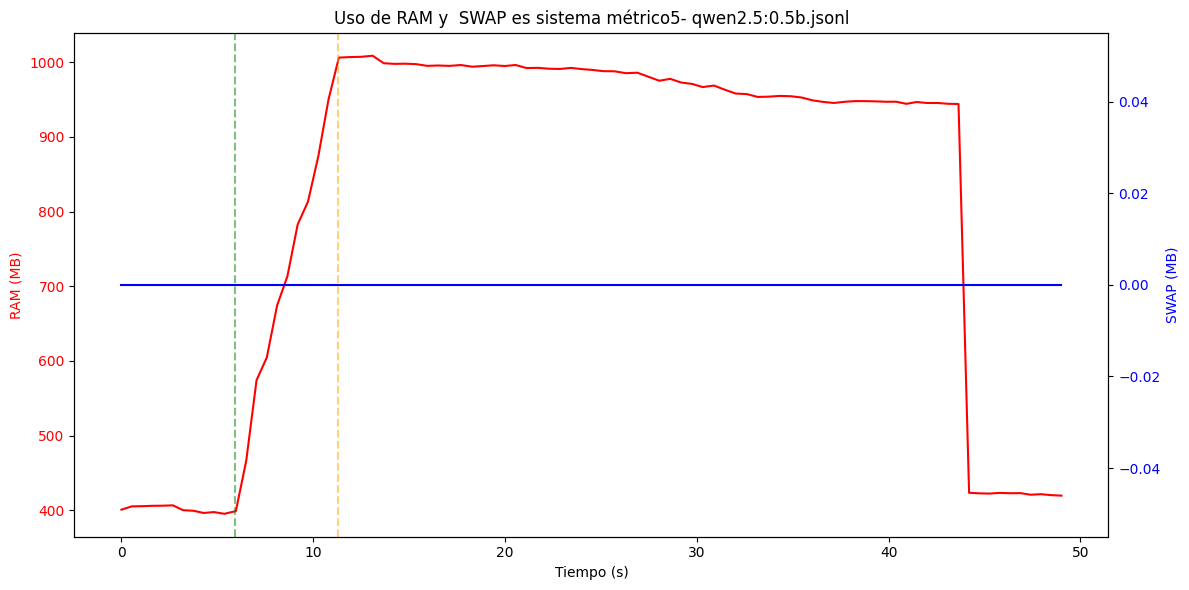

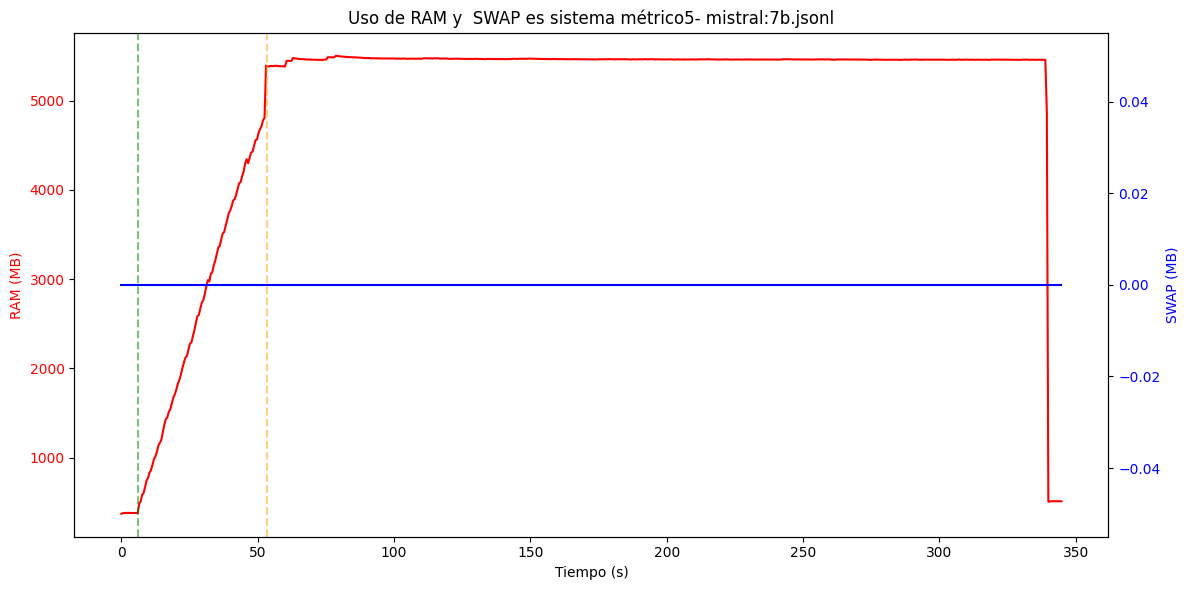

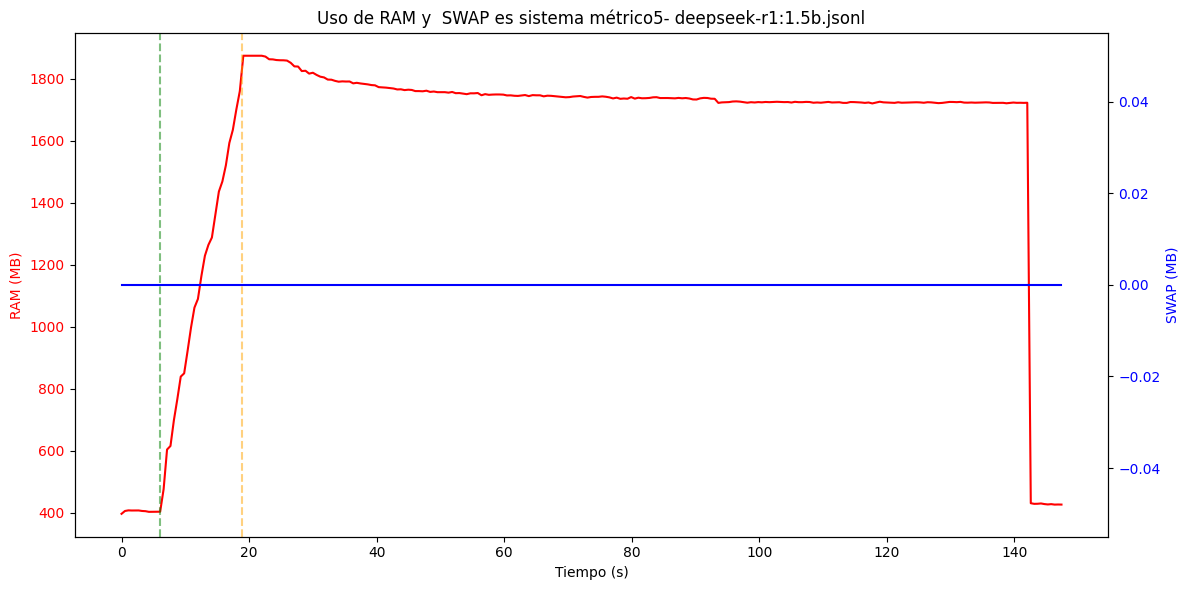

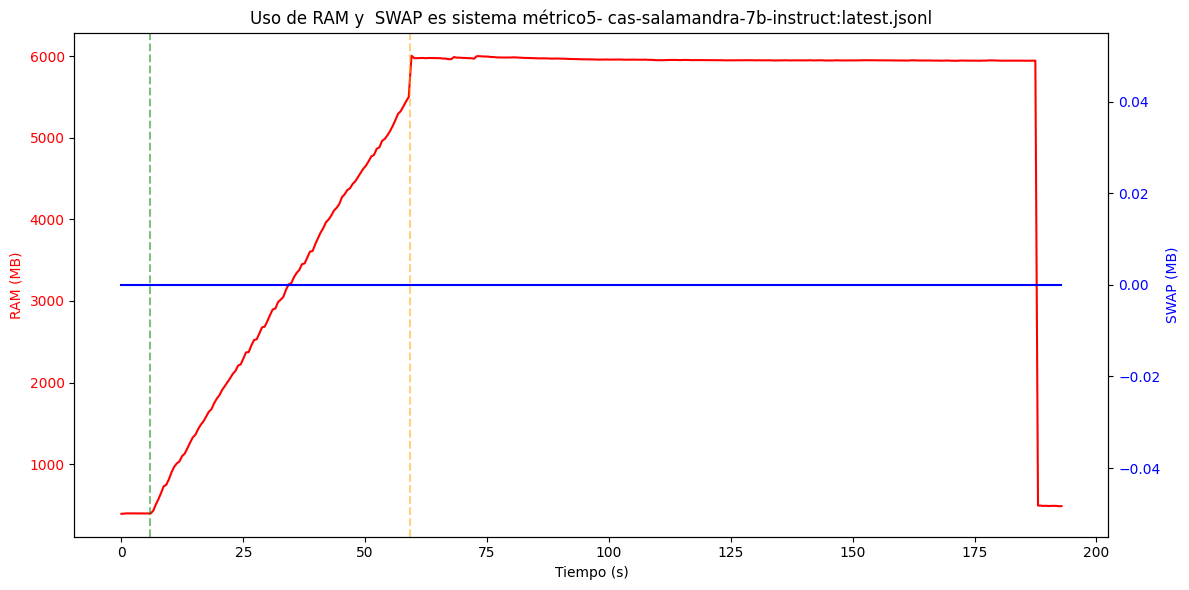

In [9]:
### RAM y SWAP
import matplotlib.pyplot as plt

def plot_ram_swap(metrics):
    """Generar gráficos de uso de RAM y SWAP para cada modelo y prompt"""
    model_name = metrics.get_model()
    hw_data = metrics.get_hardware_pd()
    prompt_data = metrics.get_prompt_metric_pd()

    if hw_data.empty:
        print(f"No hay datos de hardware para el modelo {model_name}")
        return

    # Filtrar datos inválidos
    hw_data = hw_data[hw_data['temperature'] != -1]
    

    if hw_data.empty:
        print(f"No hay datos válidos para el modelo {model_name}")
        return

    # Convertir timestamps a segundos relativos
    hw_data['time_dt'] = pd.to_datetime(hw_data['timestamp'], unit='ns')
    start_time = hw_data['time_dt'].min()
    hw_data['t_s'] = (hw_data['time_dt'] - start_time).dt.total_seconds()

    # Crear gráfico
    fig, ax1 = plt.subplots(figsize=(12, 6))

    ax1.set_title(f"Uso de RAM y  SWAP es sistema métrico5- {model_name}")
    ax1.set_xlabel("Tiempo (s)")
    ax1.set_ylabel("RAM (MB)", color="red")
    ax1.plot(hw_data['t_s'], hw_data['mem_used'] / 1_000_000, color="red", label="RAM (MB)")
    ax1.tick_params(axis="y", labelcolor="red")

    ax2 = ax1.twinx()
    ax2.set_ylabel("SWAP (MB)", color="blue") 
    ax2.plot(hw_data['t_s'], hw_data['swap_used'] / 1_000_000, color="blue", label="SWAP (MB)")
    ax2.tick_params(axis="y", labelcolor="blue")

    # Añadir líneas verticales para el tiempo de carga del modelo
    if not prompt_data.empty:
        for _, row in prompt_data.iterrows():
            start_TTLM = pd.to_datetime(row['start_timestamp'], unit='ns')
            start_TTLM_s = (start_TTLM - start_time).total_seconds()

            end_TTLM = start_TTLM + pd.Timedelta(nanoseconds=row['load_duration'])
            end_TTLM_s = (end_TTLM - start_time).total_seconds()

            ax1.axvline(x=start_TTLM_s, color='green', linestyle='--', alpha=0.5)
            ax1.axvline(x=end_TTLM_s, color='orange', linestyle='--', alpha=0.5)

    fig.tight_layout()
    plt.show()

# Generar gráficos para cada modelo
for metrics in ollama_metricas:
    plot_ram_swap(metrics)

### RAM(y swap) Y CPU 
Por las dos etapas que tiene el uso de un modelo(según el paper tutorial  de Paul ): 
1. Etapa aumento del uso de RAM(carga del modelo).
2. Etapa de aumento del uso de CPU/¿GPU?(en el caso de que proceda la GPU)(evaluación y computación de la respuesta).

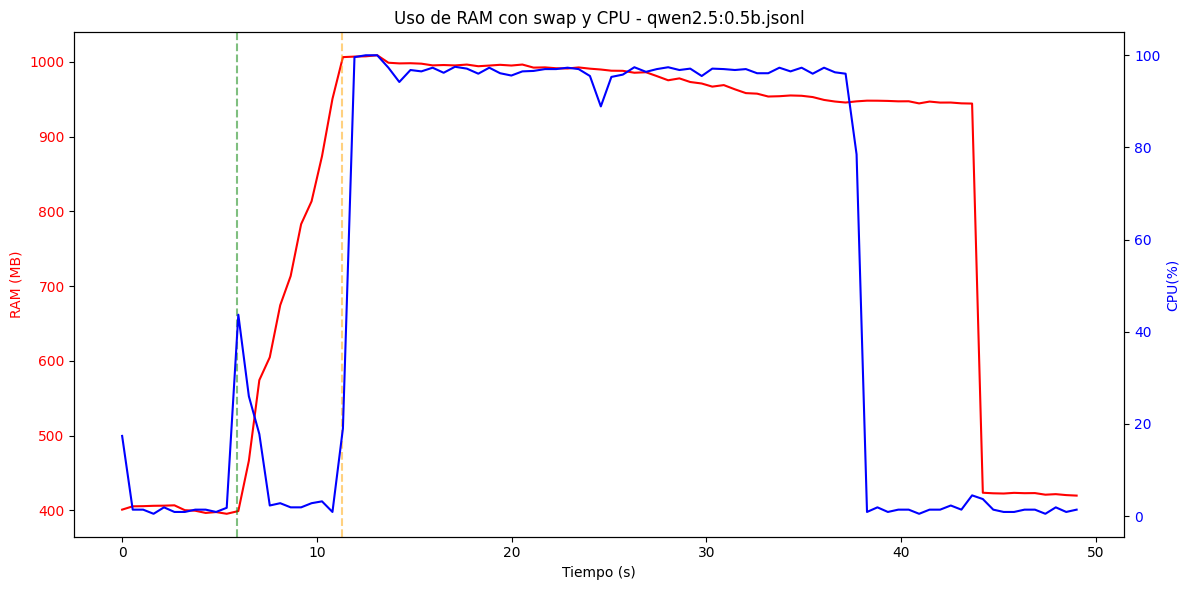

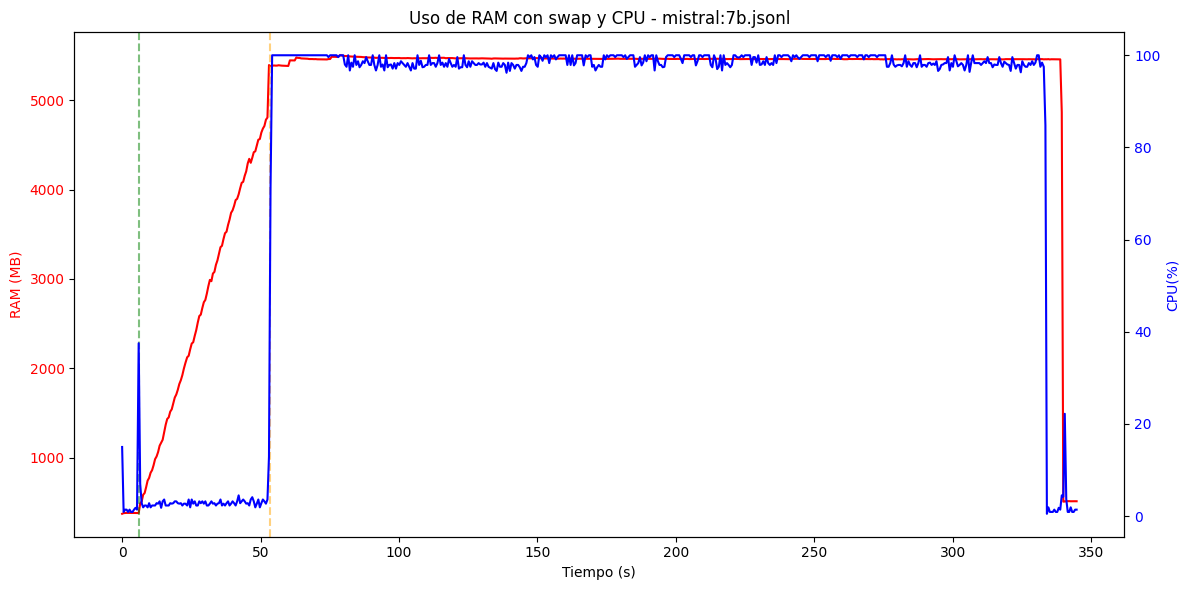

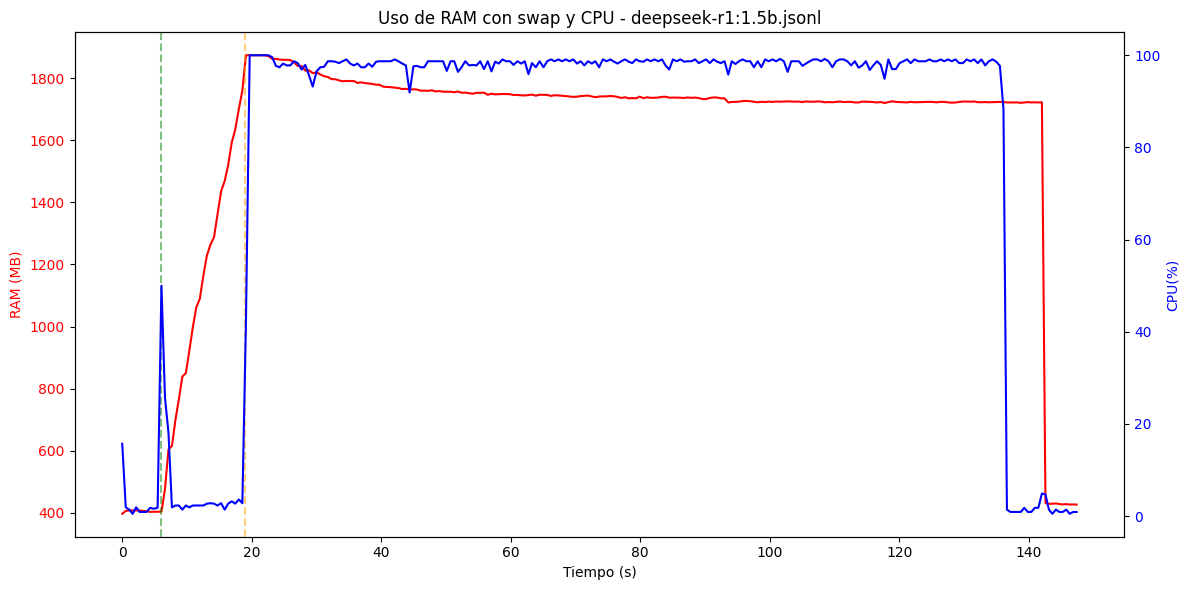

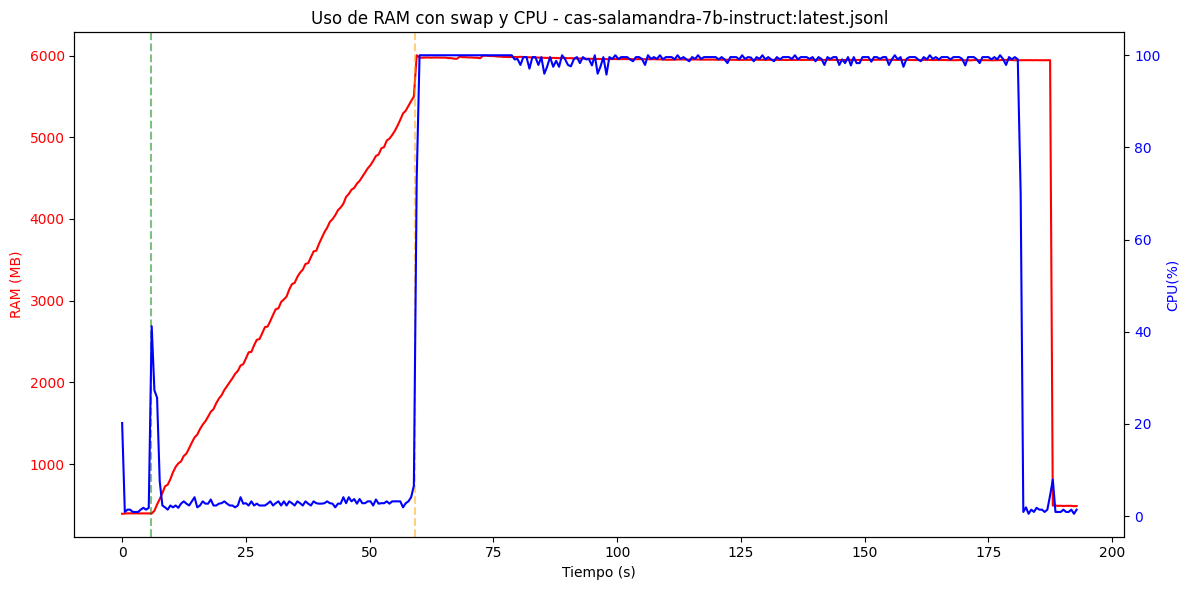

In [10]:
import matplotlib.pyplot as plt

def plot_ram_cpu(metrics):
    """Generar gráficos de uso de RAM y SWAP para cada modelo y prompt"""
    model_name = metrics.get_model()
    hw_data = metrics.get_hardware_pd()
    prompt_data = metrics.get_prompt_metric_pd()

    if hw_data.empty:
        print(f"No hay datos de hardware para el modelo {model_name}")
        return

    # Filtrar datos inválidos
    hw_data = hw_data[hw_data['temperature'] != -1]
    

    if hw_data.empty:
        print(f"No hay datos válidos para el modelo {model_name}")
        return

    # Convertir timestamps a segundos relativos
    hw_data['time_dt'] = pd.to_datetime(hw_data['timestamp'], unit='ns')
    start_time = hw_data['time_dt'].min()
    hw_data['t_s'] = (hw_data['time_dt'] - start_time).dt.total_seconds()

    # Crear gráfico
    fig, ax1 = plt.subplots(figsize=(12, 6))

    ax1.set_title(f"Uso de RAM con swap y CPU - {model_name}")
    ax1.set_xlabel("Tiempo (s)")
    ax1.set_ylabel("RAM (MB)", color="red")
    ax1.plot(hw_data['t_s'], (hw_data['mem_used'] + hw_data['swap_used']) / 1_000_000, color="red", label="RAM (MB)")
    ax1.tick_params(axis="y", labelcolor="red")

    ax2 = ax1.twinx()
    ax2.set_ylabel("CPU(%)", color="blue") 
    ax2.plot(hw_data['t_s'], hw_data['cpu_usage'], color="blue", label="CPU (%)")
    ax2.tick_params(axis="y", labelcolor="blue")
    # añado las barras para distingir el time to load model
    if not prompt_data.empty:
        for _, row in prompt_data.iterrows():
            start_TTLM = pd.to_datetime(row['start_timestamp'], unit='ns')
            start_TTLM_s = (start_TTLM - start_time).total_seconds()
            
            end_TTLM = start_TTLM + pd.Timedelta(nanoseconds=row['load_duration'])
            end_TTLM_s = (end_TTLM - start_time).total_seconds()
            
            ax1.axvline(x=start_TTLM_s, color='green', linestyle='--', alpha=0.5)
            ax1.axvline(x=end_TTLM_s, color='orange', linestyle='--', alpha=0.5)
    fig.tight_layout()
    plt.show()

# Generar gráficos para cada modelo
for metrics in ollama_metricas:
    plot_ram_cpu(metrics)

### Tabla con datos  durante token evaluation

In [17]:
import re

# Crear tablas de pandas

rows = []
cols = [ #las que se pueden generar de forma automática
        "Modelo",
        "Parametros",
        "Embedding Length",
        "Alimentación",
        "Tokens",
        "Eval Time Avg (s)",
        "TPOT (s/token)",
        "RAM Avg (MB)",
        "SWAP Avg (MB)",
        "CPU Avg (%)",
        "Freq Avg (GHz)",
        "Temp Avg (°C)",
        "Fan Avg (RPM)"

    ]
"""

    - Mistral :     parameters          7.2B , context length      32768 , embedding length    4096 , quantization ,   Q4_K_M  
    - Salamandra:  parameters      7.8B  , context length      8192  , embedding length    4096  ,quantization  Q4_K_M    
    - deepseek:      parameters          1.8B   ,context length      131072 , embedding length    1536 ,quantization        Q4_K_M  
    - qwen:      parameters          494.03M  ,context length      32768 ,  embedding length    896 ,quantization        Q4_K_M     
"""
embeddings = [869,4096,1536,4096]
parametros = [0.494, 7.2,1.8, 7.8]
for m in ollama_metricas:
    # se definen los atributos a extraer
    model = m.get_model()
    modelo_token_eval =  m.get_eval_answer();
    promp_df = modelo_token_eval.get_prompt_metric_pd()
    hardware_df= modelo_token_eval.get_hardware_pd()
    #extraemos valores de interés 
    # relacionados con el modelo 
    # Parametros del modelo (con regex)
    match = re.search(r'(\d+(\.\d+)?)\s*b', model, flags=re.IGNORECASE)
    parameters = "unkown"
    if match:
        parameters = match.group(0);
    # Propiedades alimentación 
    alimentacion_propiedades = {"context_length": "4096", "batch_size": "512"}#Esto es manual
    tokens =  promp_df['eval_count'].values[0]
    eval_time_avg =promp_df['eval_duration'].values[0]/1_000_000_000
    TPOT =  eval_time_avg / tokens
    ram_avg = hardware_df['mem_used'].mean() / 1_000_000
    swap_avg = hardware_df['swap_used'].mean()
    cpu__avg = hardware_df['cpu_usage'].mean()
    freq_avg =hardware_df['frequency'].mean()
    fan_avg=  hardware_df['fan_speed'].mean()
    temp_avg = hardware_df['temperature'].mean()
    # asociamos a cada 
    rows.append({
        "Modelo":model,
        "Parametros": parametros.pop(0),
        "Embedding Length": embeddings.pop(0),
        "Alimentación": f"context={alimentacion_propiedades['context_length']}, batch={alimentacion_propiedades['batch_size']}",
        "Tokens": tokens,
        "Eval Time Avg (s)": eval_time_avg,
        "TPOT (s/token)": TPOT,
        "RAM Avg (MB)": ram_avg,
        "SWAP Avg (MB)": swap_avg,
        "CPU Avg (%)": cpu__avg,
        "Freq Avg (GHz)": freq_avg / 1_000_000_000,
        "Temp Avg (°C)": temp_avg,
        "Fan Avg (RPM)": fan_avg

    })
resumen_token_eval = pd.DataFrame(rows, columns=cols)
resumen_token_eval




 

,Modelo,Parametros,Embedding Length,Alimentación,Tokens,Eval Time Avg (s),TPOT (s/token),RAM Avg (MB),SWAP Avg (MB),CPU Avg (%),Freq Avg (GHz),Temp Avg (°C),Fan Avg (RPM)
0,qwen2.5:0.5b.jsonl,0.494,869,"context=4096, batch=512",564,23.939862,0.042447,979.515880,0.0,96.409524,2.400026,74.569048,6511.071429
1,mistral:7b.jsonl,7.200,4096,"context=4096, batch=512",594,255.148791,0.429543,5463.078166,0.0,98.747664,2.389709,81.440187,9322.310748
2,deepseek-r1:1.5b.jsonl,1.800,1536,"context=4096, batch=512",1130,112.620485,0.099664,1748.373982,0.0,98.286294,2.398300,79.692386,8531.822335
3,cas-salamandra-7b-instruct:latest.jsonl,7.800,4096,"context=4096, batch=512",249,101.808312,0.408869,5952.313524,0.0,99.154971,2.399429,80.569591,8866.000000
